In [1]:
import sys
sys.path.append('../../../ResponsibleAIToolBox-Mitigation/')

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm

import pandas as pd
from errorsmitigation.dataprocessing import DataRebalance

from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
seed = 42
data_dir = '../../datasets/hr_promotion'
dataset_original =  pd.read_csv(data_dir + '/train.csv').drop(['employee_id'], axis=1)

dataset = dataset_original
dataset.shape
# handle duplicates
dataset = dataset.drop_duplicates()

# OneHotEncoder for categorical features
dataset = pd.get_dummies(dataset, drop_first=False)

# handle null values
dataset.dropna(inplace=True)

dataset.shape

(54808, 13)

(50628, 59)

In [3]:
# # Parameters

# dataset - A Panda Data Frame representing the data to rebalance.   

# target – A string representing the name or the label column integer index (zero base) 
    # of the target feature to use as the classes for rebalancing the data.
    
# sampling_strategy  
    # 'minority': resample only the minority class. 
    # 'not minority': resample all classes but the minority class. 
    # 'not majority': resample all classes but the majority class. 
    # 'all': resample all classes. 
    # 'auto': equivalent to 'not majority'. 
    
# random_state - Control the randomization of the algorithm. 
    # ‘None’: the random number generator is the RandomState instance used by np.random.  
    # ‘If Int’: random_state is the seed used by the random number generator. 
    
# smote_tomek - The SMOTETomek object to use. If not given by Caller, a SMOTE object with default parameters will be given. 
    #  imblearn.combine.SMOTETomek 
    
# smote - The SMOTE object to use. If not given by Caller, a SMOTE object with default parameters will be given. 
    # imblearn_over_sampling.SMOTE
    
# tomek - The TomekLinks object to use. If not given by Caller, a TomekLinks object with sampling strategy=’all’ will be given.  imblearn.under_sampling.TomekLinks

tomek = TomekLinks(sampling_strategy='auto')    
# smote = SMOTE(sampling_strategy='auto', random_state= seed)    
smote = SMOTE()    
smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=seed)


In [4]:
data_rebalance =  DataRebalance(dataset, 'is_promoted', None, None, None, smote, None)
X = data_rebalance.Rebalance()

dataset.shape
X.shape

(50628, 59)

(92600, 59)

In [5]:
data_rebalance =  DataRebalance(dataset, 'is_promoted', 'auto', seed, None, None, tomek)
X = data_rebalance.Rebalance()

X.shape

(49472, 59)

In [6]:
data_rebalance =  DataRebalance(dataset, 'is_promoted', 'auto', seed, smote_tomek)
X = data_rebalance.Rebalance()

X.shape

(92562, 59)

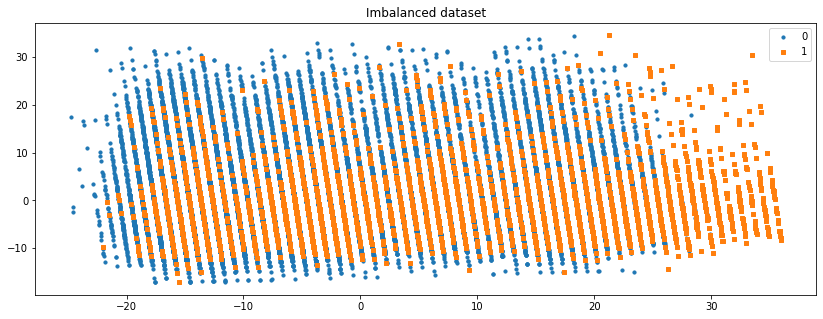

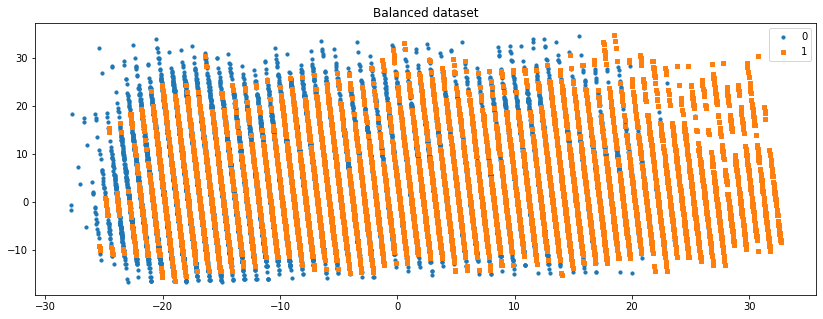

In [7]:
# Compare balanced vs imbalanced data

from sklearn.model_selection import train_test_split
import numpy as np
def split_label(dataset):
    x = dataset.drop(['is_promoted'], axis=1)
    y = dataset['is_promoted']
    return x, y

def clean_data(x, y):
    features = x.columns.values.tolist()
 
    classes = y.unique().tolist()
    pipe_cfg = {
        'num_cols': x.dtypes[x.dtypes != 'object'].index.values.tolist()
    }
    num_pipe = Pipeline([
        ('num_imputer', SimpleImputer(strategy='median')),
        ('num_scaler', StandardScaler())
    ])
    feat_pipe = ColumnTransformer([
        ('num_pipe', num_pipe, pipe_cfg['num_cols'])
    ])
    x = feat_pipe.fit_transform(x)
    return x, feat_pipe, features, classes

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    plt.figure(figsize=(14, 5))
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m, s=10
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()
    
data = dataset_original
data.dropna(inplace=True)
data = pd.get_dummies(data, drop_first=False)


# Split data into train and test
temp_train_data, temp_test_data = train_test_split(data, train_size=0.9, test_size=0.1, random_state=seed)

temp_x_train_original, temp_y_train = split_label(temp_train_data)
temp_x_train = temp_x_train_original.to_numpy()

# using PCA to flaten the multi-dimemsions data into 2
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_imb = pca.fit_transform(temp_x_train)
plot_2d_space(X_imb, temp_y_train, 'Imbalanced dataset')


# balanced dataset
data_rebalance =  DataRebalance(dataset, 'is_promoted', 'auto', seed, None, smote)
dataset = data_rebalance.Rebalance()
X = dataset.drop(['is_promoted'], axis=1)
y = dataset['is_promoted']  

X_train = pca.fit_transform(X)
plot_2d_space(X_train, y, 'Balanced dataset')
